In [1]:
from tqdm import tqdm
import numpy as np
from extra_data import open_run
from matplotlib import pyplot as plt
from scipy.ndimage import center_of_mass
from wpg.source import sase_pulse
import matplotlib.colors as mcolors

### Load Experimental Data

In [2]:
start_pulse = 9
end_pulse = 89

run = open_run("900384", 11)
cam = np.array(
    run.get_array(
        "SA1_XTD9_IMGPII45/CAM/BEAMVIEW_SHIMADZU:daqOutput", "data.image.pixels"
    ).T[
        :,
        :,
        start_pulse:end_pulse,
    ]
)

![image](./../img/use-case-1.png)

Demonstration of correlated dynamics between the electron bunch and the photon beam, attributed to instabilities in compensation kickers.

### Extract Approximate Pointing Angle

In [3]:
px = 14.9e-06  # in m
py = 10.6e-06  # in m
freq = 1.1  # MHz
z = 300  # observation plan in m

# Calculate center of mass for each (nx, ny) slice in the (nt1, nt2) data
com_p = np.array(
    [
        center_of_mass(cam[:, :, i, j])
        for i in range(cam.shape[2])
        for j in range(cam.shape[3])
    ]
)
com_p = com_p.reshape(
    cam.shape[2], cam.shape[3], 2
)  # Reshaping to (nt1, nt2, 2) for x, y coordinates
com_p = com_p[:, :, 1] * py

com_p_mean = com_p.mean(axis=1)
com_p_std = com_p.std(axis=1)

# Convert C.O.M to Pointing Angle (under geometric approximation)
theta_y_mean = com_p_mean / z
theta_y_std = com_p_std / z

### Generate Stochastic Wavefronts

In [4]:
x = y = np.linspace(-450e-06, 450e-06, 512)
t = np.linspace(-50e-15, 50e-15, 2)

wavefronts = sase_pulse(
    x=x,
    y=y,
    t=t,
    photon_energy=10e3,
    pulse_energy=1e-03,
    pulse_duration=25e-15,
    bandwidth=1e-12,
    sigma=40e-06,
    div=3.5e-06,
    x0=0.0,
    y0=0.0,
    t0=0.0,
    theta_x=0.0,
    theta_y=theta_y_mean + np.random.normal(scale=theta_y_std),
    domain="freq",
    polarization="horizontal",
)

80it [00:10,  7.54it/s]


Text(0.5, 1.0, 'Simulated Beam Profile @ Observation Point')

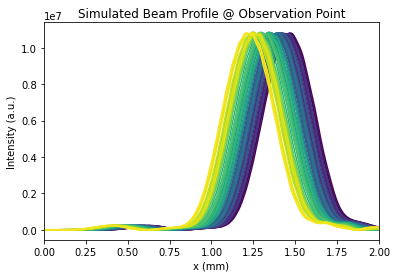

In [5]:
from wpg.beamline import Beamline
from wpg.optical_elements import Drift
from wpg.wpg_uti_oe import propagation_parameters
from wpg.wpg_uti_wf import plot_intensity_map


for itr, wfr in tqdm(enumerate(wavefronts)):
    
    bl = Beamline()
    bl.append(Drift(300), propagation_parameters(5, 1, 5, 1, 'fresnel'))
    bl.propagate(wfr)

norm = mcolors.Normalize(vmin=0, vmax=len(wavefronts))
cmap = plt.get_cmap('viridis')

fig, ax = plt.subplots(1,1)

for itr, wfr in enumerate(wavefronts):
    ax.plot(wfr.get_axis('x')*1e3, wfr.get_profile('y'), color = cmap(norm(itr)))

ax.set_xlim(0,2)
ax.set_xlabel("x (mm)")
ax.set_ylabel("Intensity (a.u.)")
ax.set_title("Simulated Beam Profile @ Observation Point")